# Adaptive binning of EPIC-pn spectra

In [1]:
import os, io
import requests
import gzip
import tarfile
import numpy as np

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')


In [2]:
def get_pn_spectrum(obsid, cache=True, cache_dir=".",verbose=True):
    #
    # Download the XMM PPS and extract the spectrum of the first/brightest source
    #
    #
    instrument = 'PN'
    substr = 'SRSPEC0001' # the first/brightest source spectrum
    ext = 'FTZ'
    #
    nxsa_url = f'https://nxsa.esac.esa.int/nxsa-sl/servlet/data-action-aio?obsno={obsid}&level=PPS'
    #
    pps_tarfile = f'{cache_dir}/{obsid}_PPS_nxsa.tar'
    if (cache and os.path.isfile(pps_tarfile)):
            print ("Found an already existing PPS tar file: {}. Will reuse it.".format(pps_tarfile))
    else:
        print (f"Downloading PPS for {obsid} from NXSA. Please wait...")
        with requests.post(nxsa_url, auth=('ivaltcha', 'Q1.2019.abc')) as r:
        #with requests.post(nxsa_url) as r:
            r.raise_for_status()
            with open(pps_tarfile, "wb") as tmp:
                tmp.write(r.content)
        print (f"Saved to {pps_tarfile}")
    #
    hdu = None
    with tarfile.open(pps_tarfile,'r') as tar:
        for member in tar.getmembers():
                if ((instrument in member.name) and (ext in member.name) and (substr in member.name)):
                    f=tar.extractfile(member)
                    hdu = fits.open(gzip.open(io.BytesIO(f.read())))
                    print (f"Extracted {member.name}")
                #
            #
        #
    return hdu

In [3]:
def plot_spectrum(spec_hdu,what='energy',xlim=(0.2,12.0),smooth = None,
                  annotation="",loglog=True,pngName=""):
    #
    # ann is an annotation to pass
    #
    spec_ext = spec_hdu['SPECTRUM']
    obsx = spec_hdu[0].header['OBS_ID']
    target = spec_hdu[0].header['OBJECT']
    #
    ebin = spec_ext.header['SPECDELT'] # the binning
    expo = spec_ext.header['EXPOSURE']/1000.0 # in ksec
    #
    channel = spec_ext.data['CHANNEL']
    energy  = channel*ebin/1000.0 # in keV
    if (what == 'energy'):
        x = energy
    else:
        x = channel
    #
    counts = spec_ext.data['COUNTS']
    #
    #
    fig,ax = plt.subplots(figsize=(15,10))
    if (loglog):
        ax.loglog(x,counts,drawstyle='steps-mid')
    else:
        ax.plot(x,counts,drawstyle='steps-mid')
    if (smooth != None):
        y = convolve(counts, Box1DKernel(smooth))
        if (loglog):
            ax.loglog(x,y,color='red')
        else:
            ax.plot(x,y,color='red')
    ymax = np.max(y[np.where((x <= xlim[1]) & (x >= xlim[0]))])
    ax.text(8.0,ymax*0.9,annotation)
    ax.set_xlim(xlim)
    ax.set_ylim((0.1,ymax))
    ax.set_title(f"OBS_ID: {obsx}, expo: {expo:.1f} ks \n {target}")
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Counts")
    ax.grid()
    # save the plot
    if (pngName != ""):
        plt.savefig(pngName)
    plt.show()
    plt.close()
#

In [4]:
wdir = os.path.expanduser('~') + '/IVAN/PN_LW'
t = Table.read(f'{wdir}/PN-LW_rev1500.csv',delimiter=",")
rev = t['OBSERVATION.REVOLUTION']
ttype = t['TARGET_TYPE.DESCRIPTION']
ann = [f"Rev: {i}, Type: {j}" for i,j in zip(rev,ttype)]

In [5]:
obsid = [f"{x:010}" for x in t['OBSERVATION.OBSERVATION_ID']]
pngNames = [f"{i}_{j}_src01_pn_specplot.png" for i,j in zip(rev,obsid)]

In [6]:
#
# this is the folder where the PPS tar files will be stored
#
tmpDir = "/lhome/ivaltchanov/XMM-data/cache"
if (not os.path.isdir(tmpDir)):
    print (f"Cache folder {tmpDir} does not exist. Will create it.")
    os.mkdir(tmpDir)

Found an already existing PPS tar file: /lhome/ivaltchanov/XMM-data/cache/0502060901_PPS_nxsa.tar. Will reuse it.
Found an already existing PPS tar file: /lhome/ivaltchanov/XMM-data/cache/0502630201_PPS_nxsa.tar. Will reuse it.
Extracted 0502630201/pps/P0502630201PNS001SRSPEC0001.FTZ


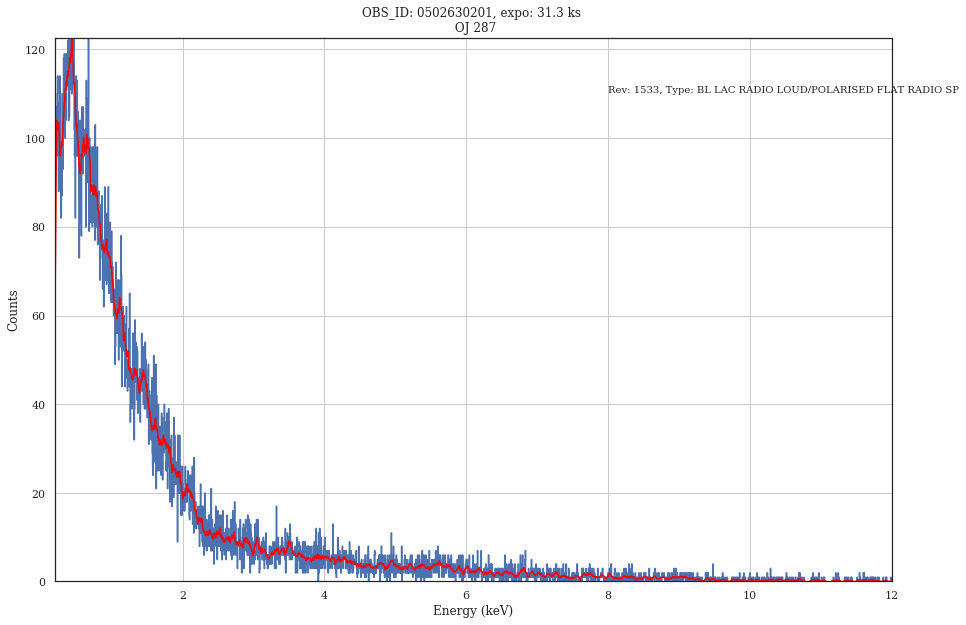

In [7]:
for i,j in enumerate(obsid):
    out_hdu = get_pn_spectrum(j,cache_dir=tmpDir)
    if (out_hdu != None):
        plot_spectrum(out_hdu,smooth = 11,annotation=ann[i],loglog=False,pngName=f"{wdir}/spec_plots/{pngNames[i]}")
        break

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/seaborn/distributions.py:340: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


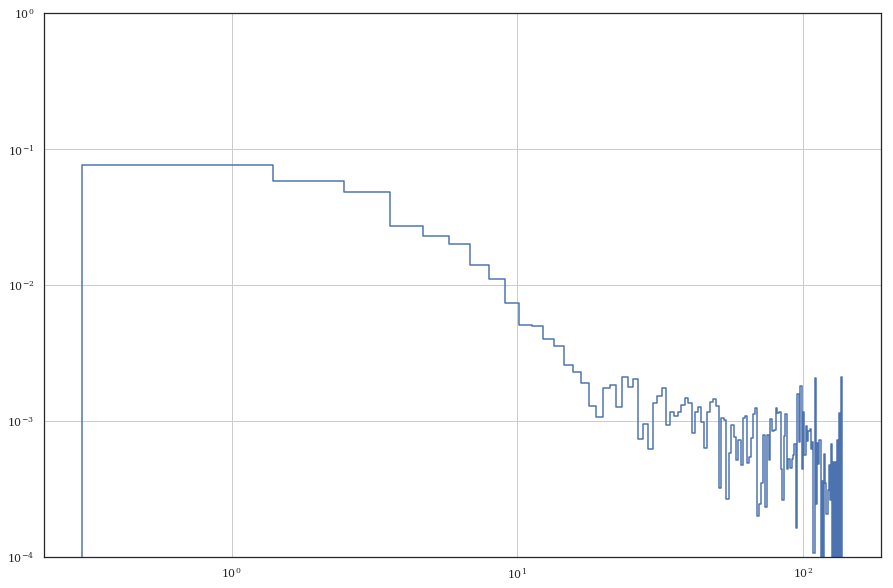

In [18]:
f, ax = plt.subplots(figsize=(15, 10))
ax.set(xscale="log", yscale="log",ylim=(1.0e-4,1.0))
ax = sns.kdeplot(out_hdu['SPECTRUM'].data['COUNTS'],kernel='gau',ax=ax,drawstyle='steps-mid');
ax.grid(True)
